# Model evaluation - RNN

Since the RNN model and the ANN models are using very differing input the RNN cannot be evaluated with the same exact notebook so this is a modified version to handle that.

This notebook will:
* Look closer on the data and predictions

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt
from collections import deque

Function needed if the RNN model is used. Converts the test data to the correct format for the RNN.

In [2]:
SEQUENCE_LENGTH = 20
def sequencify(df):
    sequencial_data = []
    sequence = deque(maxlen=SEQUENCE_LENGTH)
    for i in df.values:
        sequence.append([n for n in i[:-1]])
        if len(sequence) == SEQUENCE_LENGTH:
            sequencial_data.append([np.array(sequence), i[-1]])
    X = []
    Y = []
    for sequence, label in sequencial_data:
        X.append(sequence)
        Y.append(label)
    return np.array(X),Y

Pick the name for your model

In [3]:
model_name = 'ANN_M4'

## Load model and data

In [4]:
data = pds.read_pickle(model_name + '.pkl')
data.head()

,1,2,3,4,5,6,7,8,9,10,...,hr_sin,hr_cos,dir_sin,dir_cos,speed,tsjs,lat,lon,journey,time_left
0,1,0,0,0,0,0,0,0,0,0,...,0.840251,0.542197,0.54024,-0.841511,0.0,0.0,0.326317,0.924521,1,71.0
1,1,0,0,0,0,0,0,0,0,0,...,0.840291,0.542136,0.54024,-0.841511,0.0,0.0,0.326237,0.925287,1,70.0
2,1,0,0,0,0,0,0,0,0,0,...,0.840330,0.542075,0.54024,-0.841511,0.0,0.0,0.326156,0.925670,1,69.0
3,1,0,0,0,0,0,0,0,0,0,...,0.840370,0.542014,0.54024,-0.841511,0.0,0.0,0.326076,0.926437,1,68.0
4,1,0,0,0,0,0,0,0,0,0,...,0.840409,0.541953,0.54024,-0.841511,0.0,0.0,0.326116,0.926437,1,67.0


In [5]:
# Load YAML and create model
yaml_file = open(model_name + '.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights(model_name + '.h5')

Model needs to be compiled again

In [6]:
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 20, 128)           76288     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20, 128)           132096    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 344,641
Trainable params: 344,641
Non-trainable params: 0
_________________________________________________________________
None


Divide into labels and data, note that `journey` needs to be removed as well!

In [7]:
data_no_j = data.drop('journey', axis=1)
test_data, test_labels = sequencify(data_no_j)

General model evaluation

In [8]:
model.evaluate(test_data, test_labels)

643272/643272 [==============================] - 82s 127us/step


[9.936545697277818, 9.936545697277818]

## Start by looking at an entire journey

In [20]:
journeys = data.journey.unique()

Pick out a random journey

In [21]:
selected_journey = np.random.choice(journeys)
to_test = data[data['journey'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey'])
sequence_input, sequence_labels= sequencify(model_to_predict)
predictions = model.predict(sequence_input, batch_size=1, verbose=1)

865/865 [==============================] - 2s 3ms/step


### First plot

In [22]:
# Set window size, only needed once
plt.rcParams['figure.figsize'] = [14, 14]

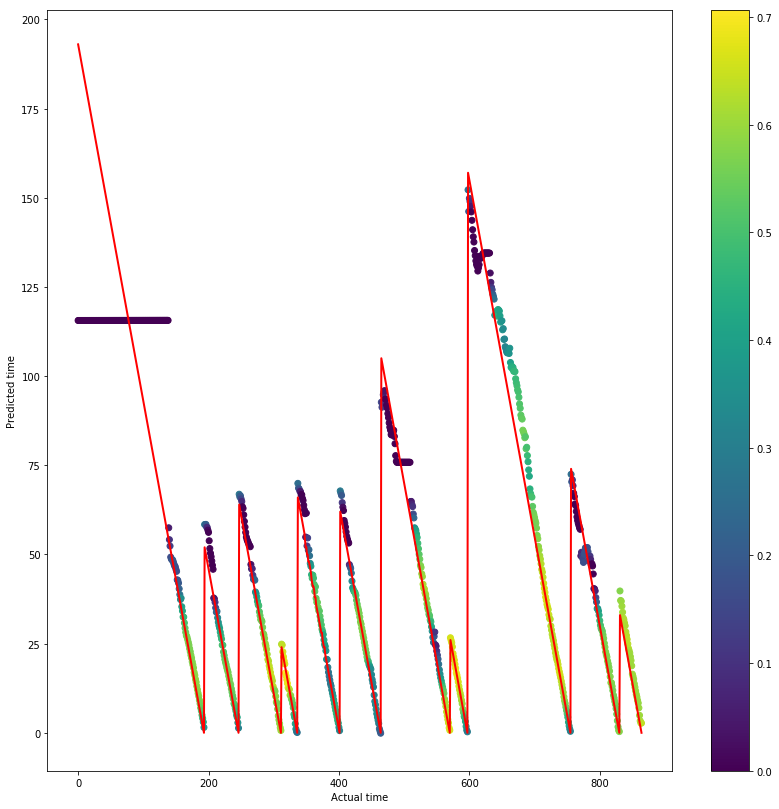

865/865 [==============================] - 0s 137us/step
MAE: [8.41074795971027, 8.41074795971027]


In [23]:
plt.plot(sequence_labels, color='red', linewidth=2, markersize=12)
plt.ylabel('Predicted time')
plt.xlabel('Actual time')

if 'speed' in model_to_predict.columns:
    #First 20 points are not predicted since sequences have length 20
    plt.scatter(range(len(predictions)), predictions, c=model_to_predict['speed'].values[SEQUENCE_LENGTH-1:]) 
    plt.colorbar()
else:
    plt.plot(predictions, color='green', linewidth=2, markersize=12)
    
    
plt.show()
print('MAE:', model.evaluate(sequence_input, sequence_labels))

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time. This does not seem to apply to model M1 though!

Also, the color is normalized speed (0-1)

### Scatterplot of test data

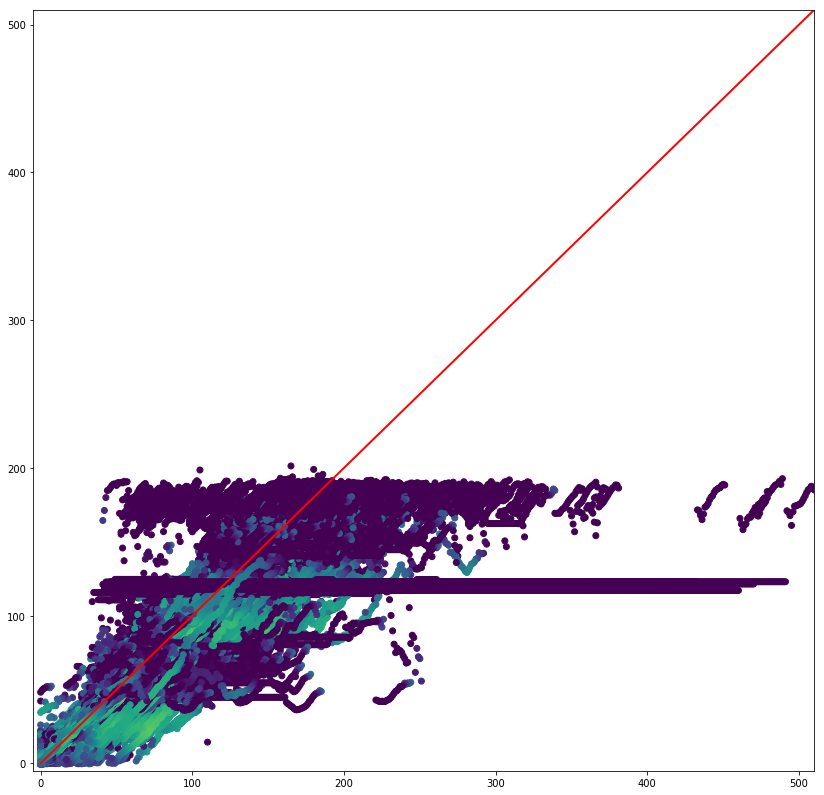

In [29]:
test_predictions = model.predict(test_data)
color = None
if 'speed' in data.columns:
    color = data['speed'].values[SEQUENCE_LENGTH-1:]
plt.scatter(test_labels, test_predictions, c=color)
max_time = np.int_(np.round(np.append(np.transpose(test_labels), test_predictions).max()))
plt.xlim(-5, max_time)
plt.ylim(-5, max_time)
plt.plot(range(max_time),range(max_time), color='red', linewidth=2)
plt.show()

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [42]:
# Drop first segment, all journeys
test_ign = data[data[1] == 0].index
test_ign_data = data.loc[test_ign]
test_ign_data = test_ign_data.drop(columns=['journey'])
test_ign_d, test_ign_l = sequencify(test_ign_data)

# Drop first segment, single journey

# Selected_journey from previous section is used to compare loss
test_single_j = data[data['journey'] == selected_journey]
to_test = test_single_j.drop(columns=['journey'])


test_single = to_test[to_test[1] == 0].index
test_single_data = to_test.loc[test_single]

test_single_d, test_single_l = sequencify(test_single_data)

Evaluate model on all data

In [43]:
model.evaluate(test_ign_d, test_ign_l)

508447/508447 [==============================] - 64s 125us/step


[6.483860633422624, 6.483860633422624]

In general, alla models benefit from removing the first segment. There is probably a lot of dwell time at the start of the segment.

In [44]:
predictions_ = model.predict(test_single_d, batch_size=1, verbose=1)

652/652 [==============================] - 2s 3ms/step


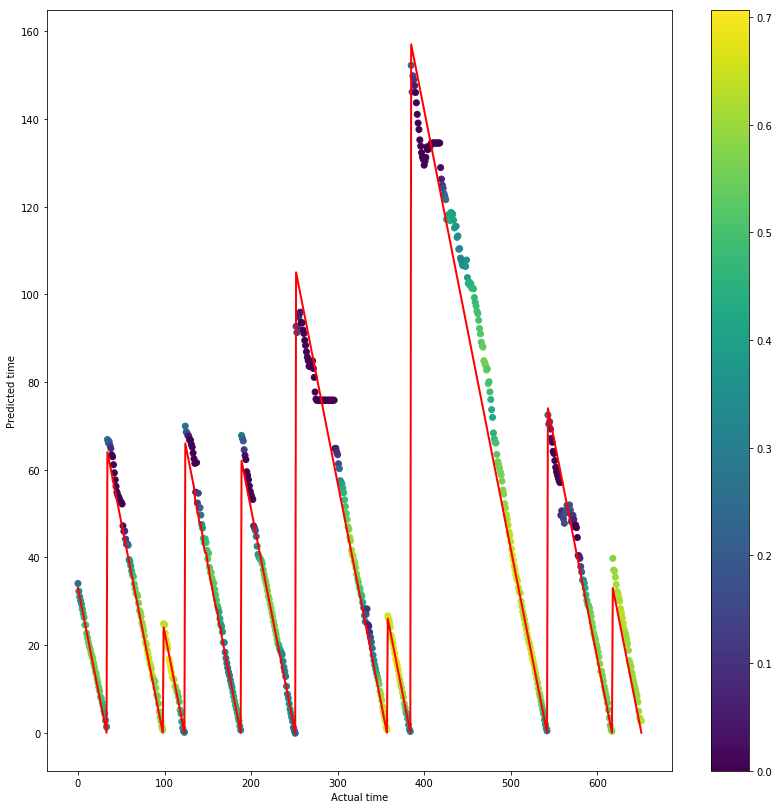

652/652 [==============================] - 0s 135us/step
MAE: [3.3201624776688092, 3.3201624776688092]


In [46]:
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
if 'speed' in model_to_predict.columns:
    plt.scatter(range(len(predictions_)),predictions_, c=test_single_data['speed'].values[19:])
    plt.colorbar()
else:
    plt.plot(predictions_, color='green', linewidth=2, markersize=12)

plt.ylabel('Predicted time')
plt.xlabel('Actual time')
plt.show()
print('MAE:', model.evaluate(test_single_d, test_single_l))

## Now, lets look only at segment 9 (McD to Gamla Linköping for line 3)

In [49]:
# Select segment 9 for all journeys
test_ign = data[data[9] == 1].index
test_ign_data = data.loc[test_ign]
test_ign_d, test_ign_l = sequencify(test_ign_data)

In [50]:
eval_data = []
eval_labels = []

for i, seg in test_ign_data.groupby('journey'):
    n_seg_data = seg.drop(columns=['journey'])
    n_seg_d, n_seg_l = sequencify(n_seg_data)
    pred = model.predict(n_seg_d, verbose=0)
    eval_data.append([pred])
    eval_labels.append([n_seg_l])

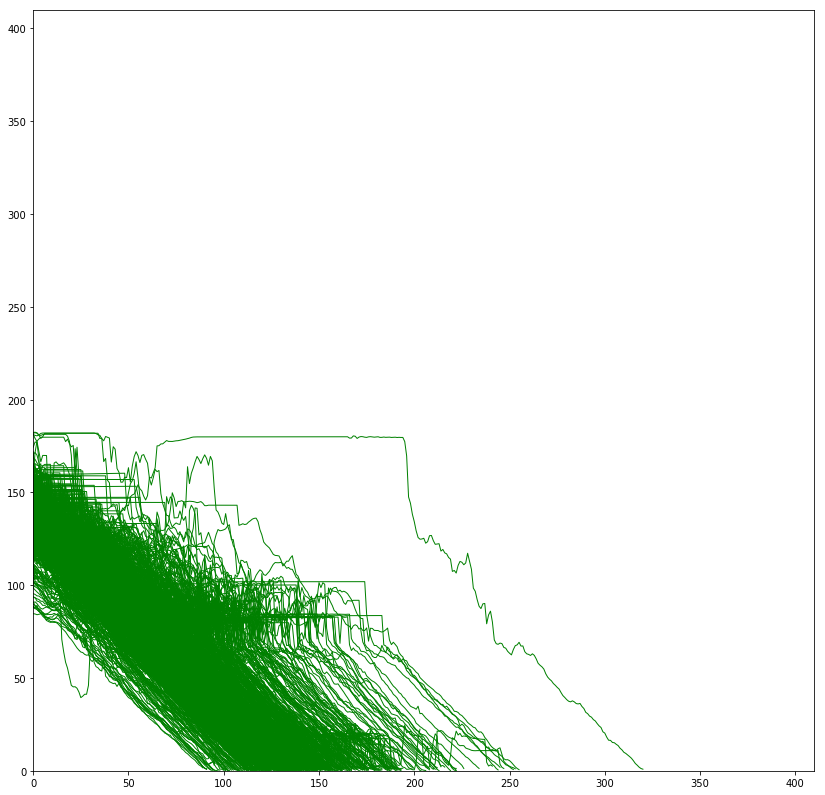

In [51]:
for i in range(len(eval_data)):
    plt.plot(eval_data[i][0], color='green', linewidth=1, markersize=2)
    #plt.plot(eval_labels[i][0], color='red', linewidth=2, markersize=12)
    
plt.xlim(0, max_time-100)
plt.ylim(0, max_time-100)
plt.show()

For bus line 3:

There seems to be large variance in this segment. This is the segment containing Vallarondellen, which is known for having large traffic issues during rush hours. This is probably why some journeys are very far to the right and the actual travel time ranges from 100-350 seconds.